# Branched Retrieval Augmented Generation (RAG) with OpenAI

Performs multiple retrieval steps, refining the search based on intermediate results

**When to use:** Complex queries requiring multi-step reasoning or information synthesis

Author: [Manoj Jahgirdar](https://www.linkedin.com/in/manojjahgirdar)

## Retrieval-Augmented Generation (RAG) Pipeline

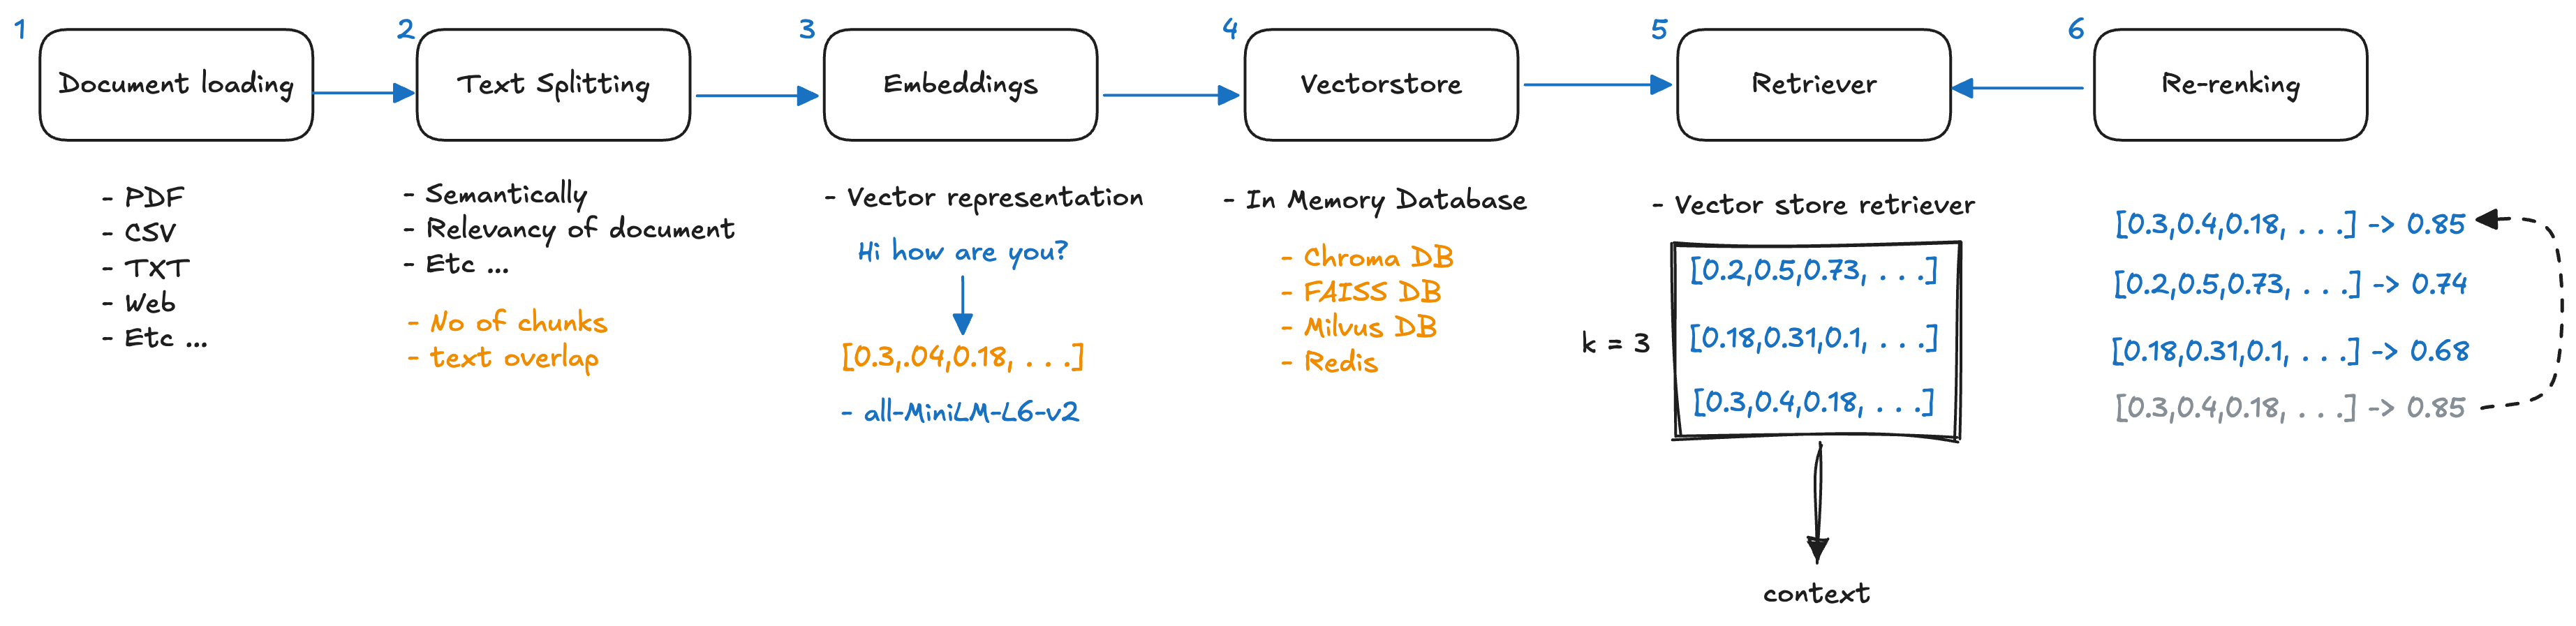

## Install dependencies

In [ ]:
%pip install --quiet --upgrade sentence-transformers faiss-cpu rank_llm pymupdf
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-chroma langchain_openai langchain-huggingface

## Export environment variables

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "rag-techniques"

## Step 1: Document Loading

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

In [4]:
file_path = "documents/formula1-technical-regulations.pdf"
loader = PyMuPDFLoader(file_path)
docs = loader.load()
print(f"{len(docs)} Pages loaded")

179 Pages loaded


## Step 2: Text splitting

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
print(f"{len(docs)} Pages split into '{len(all_splits)}' chunks")

179 Pages split into '682' chunks


## Step 3: Embeddings

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings

In [8]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## Step 4: Define Vectorstore

In [9]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="formula-one",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [10]:
_ = vector_store.add_documents(documents=all_splits)

## Step 5: Retriever

In [11]:
# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i + 1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [12]:
retrieved_docs = vector_store.similarity_search("What are the dimensional and mass constraints on power units, and how do they integrate with energy recovery systems?", k=3)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
# pretty_print_docs(retrieved_docs)

## Define Large Language Model (LLM)

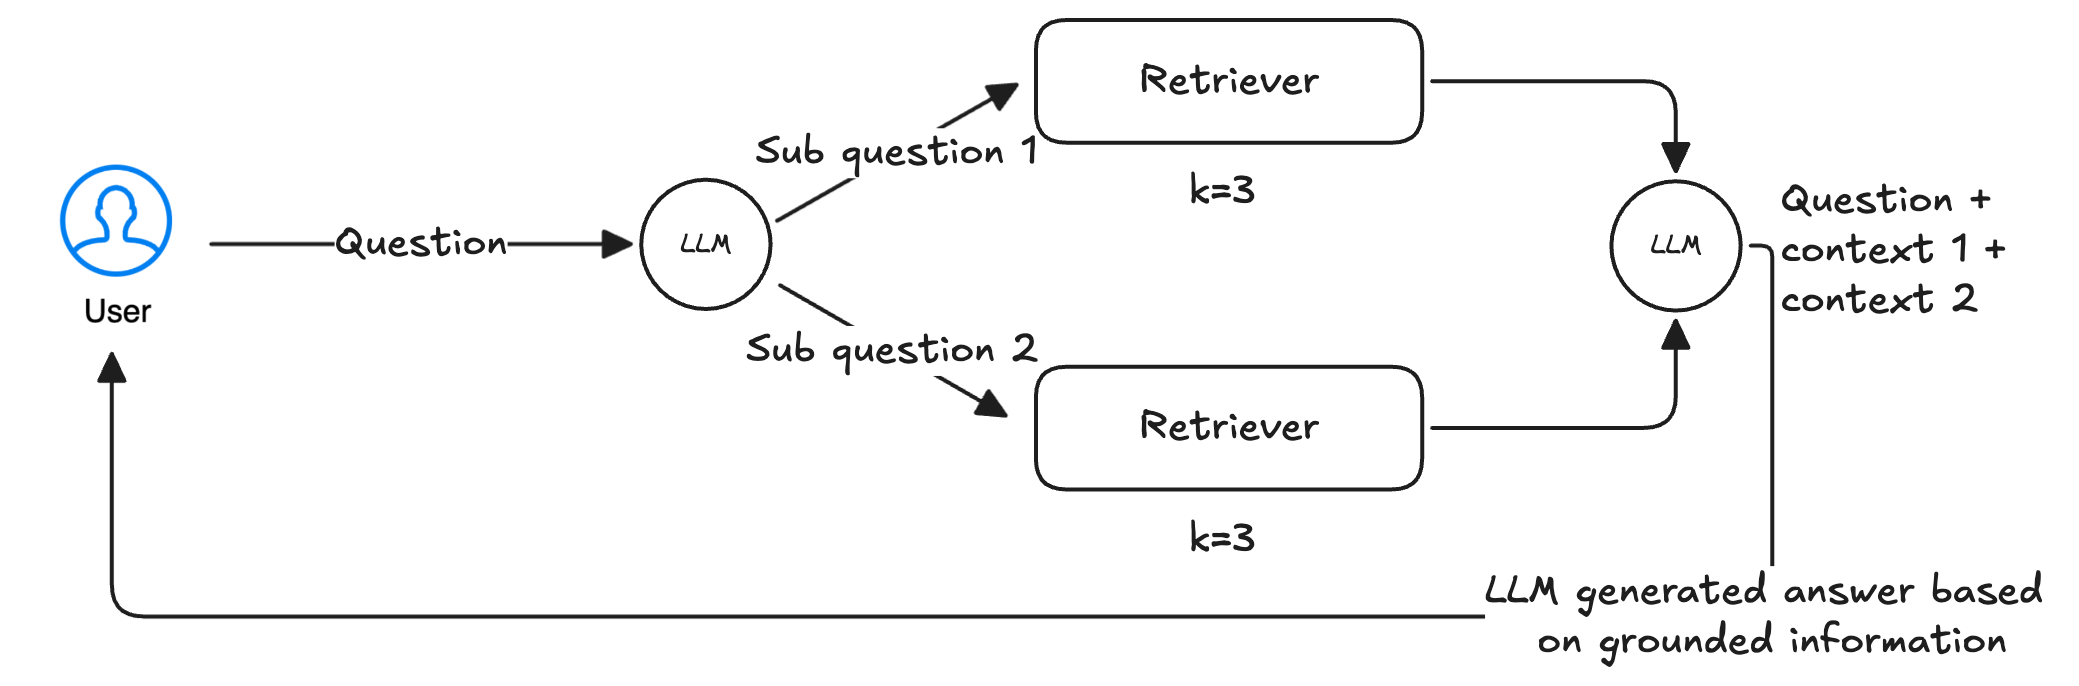

In [15]:
import getpass
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [16]:
prompt = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Keep the answer concise.

Context: 
{context} 

Question: 
{question} 

Answer: (with references)"""

## Define Graph with LangGraph

In [17]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [18]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.format(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"answer": response.content}

In [19]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

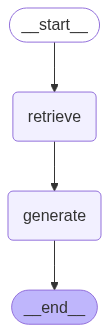

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result = graph.invoke({"question": "What are the dimensional and mass constraints on power units, and how do they integrate with energy recovery systems?"})

# print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Answer: I don't know.


## As you could see Simple RAG didn't work for this question. Let's implement the Branched RAG to get the answer

## Branched RAG setup

In [22]:
split_prompt = """You are a helpful assistant that breaks down complex questions into sub-questions.
Question: {question}
Sub-questions:
1."""

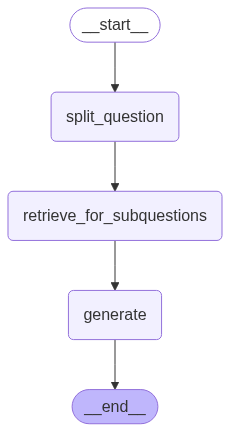

In [23]:
class State(TypedDict):
    question: str
    sub_questions: List[str]
    context: List[Document]
    answer: str

def split_question(state: State):
    messages = split_prompt.format(question=state["question"])  # You define this prompt
    response = llm.invoke(messages)
    sub_questions = [q.strip() for q in response.content.split("\n") if q.strip()]
    return {"sub_questions": sub_questions}

def retrieve_for_subquestions(state: State):
    all_docs = []
    for sub_q in state["sub_questions"]:
        retrieved = vector_store.similarity_search(sub_q)
        all_docs.extend(retrieved)
    return {"context": all_docs}

graph_builder = StateGraph(State)

graph_builder.add_node("split_question", split_question)
graph_builder.add_node("retrieve_for_subquestions", retrieve_for_subquestions)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "split_question")
graph_builder.add_edge("split_question", "retrieve_for_subquestions")
graph_builder.add_edge("retrieve_for_subquestions", "generate")

branched_rag_graph = graph_builder.compile()

display(Image(branched_rag_graph.get_graph().draw_mermaid_png()))

In [26]:
result = branched_rag_graph.invoke({"question": "What are the dimensional and mass constraints on power units, and how do they integrate with energy recovery systems?"})

# print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Answer: The dimensional and mass constraints on power units include:

1. **Overall Mass**: The power unit must have a minimum mass of 151 kg (5.5.1).
2. **Center of Gravity**: It must be positioned above Z=200 (5.5.2).
3. **Energy Store Mass**: The total mass of the energy storage part (cells and connections) must be no less than 20 kg and no more than 25 kg (5.5.3).
4. **Piston Mass**: The mass of a piston must not be less than 300 g (5.5.4).
5. **Connecting Rod Mass**: A connecting rod must also have a minimum mass of 300 g (5.5.5).
6. **Crankshaft Assembly Mass**: The mass of the complete crankshaft assembly has specific yet unlisted constraints (5.5.6).

Regarding the integration with energy recovery systems (ERS), the ERS is designed to recover energy from the car, store it, and make it available for propulsion and ancillary systems (5.1.5). Components like the Motor Generator Units (MGUs) link to the drive train and exhaust turbine of the pressure charging system (5.1.6, 5.1.7). 

## You can see how the question was broken down into sub questions for a better retrieval

In [30]:
print(f"The subquestions formed were: \n{'\n'.join(result["sub_questions"])}")

The subquestions formed were: 
1. What are the standard units of power and how are they defined in terms of dimensional analysis?
2. How do mass and dimensional constraints influence the design and efficiency of power units?
3. What are the typical energy recovery systems, and how do they function in the context of power generation?
4. How do dimensional constraints of energy recovery systems impact their integration with power units?
5. What role does efficiency play in the relationship between mass constraints and power units in energy recovery systems?
6. How do various types of power units (e.g., mechanical, electrical) differ in their dimensional and mass constraints?
7. What are the engineering trade-offs when integrating power units with energy recovery systems concerning mass and dimensions?
8. How do regulations or standards influence the design of power units in relation to mass and dimensional constraints?
9. What examples exist of successful integration of power units and e

---